### This notebook generate the line benefits from the operational cost

In [17]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [18]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [19]:
#%% Setting up the path a cases
DirName  = os.getcwd()

CSV_name =  'oT_Data_Profiles_3-bus'

CaseName_Base     = '3-bus'
CaseName_ByStages = CaseName_Base+'_ByStages'

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [60]:
df_1 = pd.read_csv(CSV_name+'.csv', index_col=0)
diff_df_1 = df_1

In [61]:
#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [62]:
diff_df_1.head()

,Unnamed: 1,Unnamed: 2,Demand,Wind,Solar,Hydro
sc01,y2030,2030-01-01T00:00:00+01:00,138.000000,39.268750,0.0001,0
sc01,y2030,2030-01-01T01:00:00+01:00,136.171458,36.176400,0.0001,0
sc01,y2030,2030-01-01T02:00:00+01:00,134.222001,33.554569,0.0001,0
sc01,y2030,2030-01-01T03:00:00+01:00,134.368377,32.191600,0.0001,0
sc01,y2030,2030-01-01T04:00:00+01:00,139.802972,30.223125,0.0001,0


In [63]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [64]:
diff_df_1.head()

,Unnamed: 1,Unnamed: 2,Demand,Wind,Solar,Hydro
LoadLevel,,,,,,
2030-01-01T00:00:00+01:00,y2030,2030-01-01T00:00:00+01:00,138.000000,39.268750,0.0001,0
2030-01-01T01:00:00+01:00,y2030,2030-01-01T01:00:00+01:00,136.171458,36.176400,0.0001,0
2030-01-01T02:00:00+01:00,y2030,2030-01-01T02:00:00+01:00,134.222001,33.554569,0.0001,0
2030-01-01T03:00:00+01:00,y2030,2030-01-01T03:00:00+01:00,134.368377,32.191600,0.0001,0
2030-01-01T04:00:00+01:00,y2030,2030-01-01T04:00:00+01:00,139.802972,30.223125,0.0001,0


In [65]:
# Selecting the columns demand, wind, solar, hydro
diff_df_1 = diff_df_1[['Demand', 'Wind', 'Solar', 'Hydro']]

In [66]:
ddf_1 = diff_df_1.stack()

In [67]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [68]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [55]:
ddf_1.head()

Value
LoadLevel                 Execution            
2030-01-01T00:00:00+01:00 Demand     138.000000
                          Wind        39.268750
                          Solar        0.000100
                          Hydro        0.000000
2030-01-01T01:00:00+01:00 Demand     136.171458

In [69]:
ddf_1 = ddf_1.reset_index()

In [70]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [74]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

In [75]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
34939,2030-12-30T22:00:00+01:00,Hydro,0.000000,2030-12-30 22:00:00
34940,2030-12-30T23:00:00+01:00,Demand,141.783412,2030-12-30 23:00:00
34941,2030-12-30T23:00:00+01:00,Wind,58.967719,2030-12-30 23:00:00
34942,2030-12-30T23:00:00+01:00,Solar,0.000100,2030-12-30 23:00:00
34943,2030-12-30T23:00:00+01:00,Hydro,0.000000,2030-12-30 23:00:00


#### Getting day of year and month

In [76]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [77]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,2030-01-01T00:00:00+01:00,Demand,138.000000,2030-01-01 00:00:00,0,1,1,1
1,2030-01-01T00:00:00+01:00,Wind,39.268750,2030-01-01 00:00:00,0,1,1,1
2,2030-01-01T00:00:00+01:00,Solar,0.000100,2030-01-01 00:00:00,0,1,1,1
3,2030-01-01T00:00:00+01:00,Hydro,0.000000,2030-01-01 00:00:00,0,1,1,1
4,2030-01-01T01:00:00+01:00,Demand,136.171458,2030-01-01 01:00:00,1,1,1,1


#### Generation new ID considering each line, and hour

In [78]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [79]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
34939,2030-12-30T22:00:00+01:00,Hydro,0.000000,2030-12-30 22:00:00,22,364,1,12,Hydro_22
34940,2030-12-30T23:00:00+01:00,Demand,141.783412,2030-12-30 23:00:00,23,364,1,12,Demand_23
34941,2030-12-30T23:00:00+01:00,Wind,58.967719,2030-12-30 23:00:00,23,364,1,12,Wind_23
34942,2030-12-30T23:00:00+01:00,Solar,0.000100,2030-12-30 23:00:00,23,364,1,12,Solar_23
34943,2030-12-30T23:00:00+01:00,Hydro,0.000000,2030-12-30 23:00:00,23,364,1,12,Hydro_23


In [80]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [81]:
table.tail()

Variable     Demand_0    Demand_1   Demand_10   Demand_11   Demand_12  \
Month Day                                                               
12    360  147.097979  143.148911  173.186858  172.420539  170.519868   
      361  150.815641  146.530654  165.262821  162.055071  158.051423   
      362  145.270244  141.427465  170.482731  166.739195  163.853736   
      363  144.395150  139.687430  158.704135  155.498609  151.355877   
      364  139.645559  135.387829  158.061305  155.147894  151.422818   

Variable    Demand_13   Demand_14   Demand_15   Demand_16   Demand_17  ...  \
Month Day                                                              ...   
12    360  169.713140  167.906250  168.004653  174.688023  177.216484  ...   
      361  155.607221  154.045582  153.841030  162.195729  168.798516  ...   
      362  161.799605  159.658216  159.571013  167.436797  171.544701  ...   
      363  148.370947  144.770543  143.161575  149.912210  159.322663  ...   
      364  149.263599  147.522666  147.491648  156.359284  164.812812  ...   

Variable     Wind_21    Wind_22    Wind_23     Wind_3     Wind_4     Wind_5  \
Month Day                                                                     
12    360  42.912244  45.173262  46.446337  37.520981  38.213131  38.282463   
      361  77.496506  79.333675  79.262719  41.155269  41.342306  41.364000   
      362  73.474444  68.724531  62.190381  69.589781  66.630925  65.308450   
      363  33.463706  34.019750  33.428156  48.939188  41.383506  37.457369   
      364  66.777213  65.176869  58.967719  33.599300  33.949319  34.304812   

Variable      Wind_6     Wind_7     Wind_8     Wind_9  
Month Day                                              
12    360  38.869056  41.186069  43.316206  43.671200  
      361  41.992094  43.820325  47.671487  50.719006  
      362  67.115737  67.506213  67.102819  67.355831  
      363  36.353012  34.937787  33.271906  32.523800  
      364  35.760819  36.808175  39.324913  41.871538  

[5 rows x 96 columns]

In [82]:
table = table.reset_index()

In [83]:
table = table.set_index(['Day'])

In [84]:
table.tail()

Variable,Month,Demand_0,Demand_1,Demand_10,Demand_11,Demand_12,Demand_13,Demand_14,Demand_15,Demand_16,...,Wind_21,Wind_22,Wind_23,Wind_3,Wind_4,Wind_5,Wind_6,Wind_7,Wind_8,Wind_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,147.097979,143.148911,173.186858,172.420539,170.519868,169.713140,167.906250,168.004653,174.688023,...,42.912244,45.173262,46.446337,37.520981,38.213131,38.282463,38.869056,41.186069,43.316206,43.671200
361,12,150.815641,146.530654,165.262821,162.055071,158.051423,155.607221,154.045582,153.841030,162.195729,...,77.496506,79.333675,79.262719,41.155269,41.342306,41.364000,41.992094,43.820325,47.671487,50.719006
362,12,145.270244,141.427465,170.482731,166.739195,163.853736,161.799605,159.658216,159.571013,167.436797,...,73.474444,68.724531,62.190381,69.589781,66.630925,65.308450,67.115737,67.506213,67.102819,67.355831
363,12,144.395150,139.687430,158.704135,155.498609,151.355877,148.370947,144.770543,143.161575,149.912210,...,33.463706,34.019750,33.428156,48.939188,41.383506,37.457369,36.353012,34.937787,33.271906,32.523800
364,12,139.645559,135.387829,158.061305,155.147894,151.422818,149.263599,147.522666,147.491648,156.359284,...,66.777213,65.176869,58.967719,33.599300,33.949319,34.304812,35.760819,36.808175,39.324913,41.871538


#### Split data table into data X and class labels y

In [85]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [86]:
print(X)
print(y)

[[138.         136.1714579  149.216963   ...  24.21408125  21.92371875
   18.496325  ]
 [137.2603099  132.5981181  165.250337   ...  20.1617125   18.96156875
   17.25559375]
 [139.6968647  134.0839398  161.4537046  ...  20.30471875  20.6426125
   21.78600625]
 ...
 [145.2702444  141.4274652  170.4827314  ...  67.5062125   67.10281875
   67.35583125]
 [144.3951504  139.6874298  158.7041348  ...  34.9377875   33.27190625
   32.5238    ]
 [139.6455593  135.387829   158.0613047  ...  36.808175    39.3249125
   41.8715375 ]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6

## PCA step by step

#### Standardizing of the data

In [87]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [88]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.14545786  0.09433328 -0.1187383  ...  0.          0.
   0.        ]
 [-0.14412056  0.09341842 -0.12228758 ...  0.          0.
   0.        ]
 [-0.15720292  0.09298442 -0.07384124 ...  0.          0.
   0.        ]
 ...
 [ 0.1226648   0.16120824  0.01798227 ...  0.          0.
   0.        ]
 [ 0.12579102  0.15843783  0.01071482 ...  0.          0.
   0.        ]
 [ 0.12431238  0.16181738  0.00680184 ...  0.          0.
   0.        ]]

Eigenvalues 
[3.12327388e+01 1.75272811e+01 7.67775400e+00 3.22939456e+00
 2.57107432e+00 2.14631929e+00 1.66304787e+00 1.49228760e+00
 1.20724831e+00 5.78600812e-01 4.20059974e-01 3.42118074e-01
 2.73730263e-01 2.66986412e-01 2.37887015e-01 1.99035836e-01
 1.84974128e-01 1.68657648e-01 1.21041016e-01 1.09745914e-01
 8.25172853e-02 8.08304807e-02 7.01652947e-02 4.84937501e-02
 4.23369567e-02 4.05469368e-02 3.32527957e-02 2.70914411e-02
 1.74913496e-02 1.51097467e-02 1.16830819e-02 1.04598670e-02
 8.20029567e-03 6.66054218e-03 6.2744510

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [90]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [91]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
31.232738776240314
17.5272810709578
7.67775400208688
3.2293945581967316
2.571074324264194
2.14631928759738
1.6630478728420117
1.4922875996632359
1.207248312644164
0.5786008115938148
0.42005997357748415
0.3421180742986841
0.27373026286124136
0.2669864122224114
0.23788701474866455
0.19903583644531994
0.18497412805717398
0.1686576483236226
0.12104101552259829
0.10974591398524143
0.08251728530547586
0.08083048069971933
0.07016529472878831
0.04849375010836923
0.04233695670547765
0.040546936764350096
0.03325279567186598
0.027091441129896008
0.017491349610775274
0.015109746728073206
0.011683081910041252
0.010459867005270154
0.008200295673317296
0.006660542179455396
0.006274451022545928
0.005641322302450854
0.004786043354613871
0.004361449757707622
0.003724908660071217
0.003294736807992131
0.0028097629949186452
0.0024138791673476235
0.0019887023983653973
0.0018568407371830028
0.001569659231046873
0.0014456086726837606
0.0014298397463155732
0.0012563674175362185

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [92]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [93]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

43.25963131782373 0
67.53619965099561 1
78.17045141670661 2
82.643399465491 3
86.20452576169026 4
89.17733521452088 5
91.48077835341607 6
93.54770600404854 7
95.21983336016054 8
96.02123787255582 9
96.60305170958507 10
97.07691030608395 11


Then

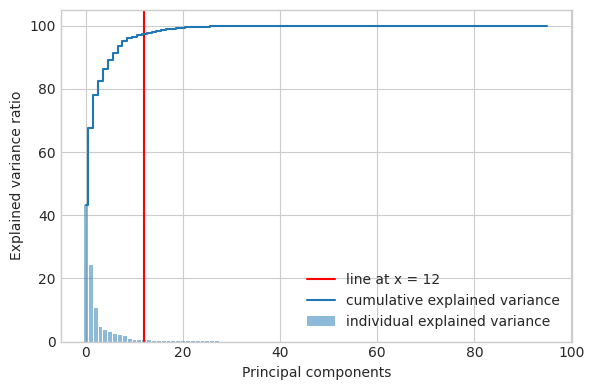

In [94]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [95]:
labels = np.unique(y, axis=0)

In [96]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

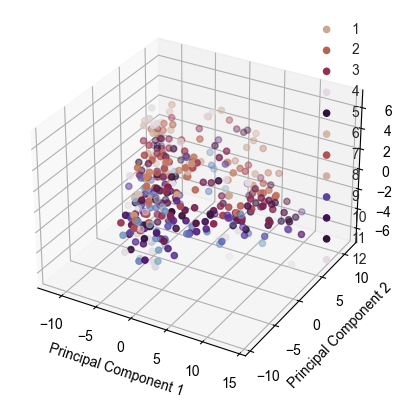

In [97]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

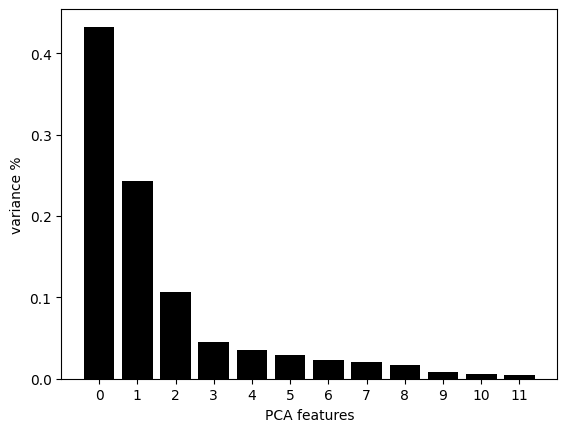

In [98]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [99]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [100]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-2.913458,-4.816244,0.460512,-1.033876,-2.127744,-0.620168,0.344810,0.069820,1.443822,-0.354933,-0.642428,0.364226
1,-0.973405,-6.075418,-0.566130,-1.045496,-1.169217,-0.375941,0.284078,-0.308592,0.342637,0.136414,-1.443007,0.466808
2,-2.090255,-4.559340,0.338325,-1.385539,-0.356562,1.697175,-0.056008,-0.303443,0.925637,0.183384,-1.259921,0.284838
3,-3.396261,-4.316245,0.861534,-0.752821,-1.285328,-0.889349,0.247559,-0.163969,0.277942,0.452710,-1.341354,0.048829
4,-1.048156,-7.590321,-0.643585,-1.307429,0.078125,0.289807,0.368203,-0.391470,0.424493,0.487755,-1.204114,0.003578


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\erik_\miniconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\erik_\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for 

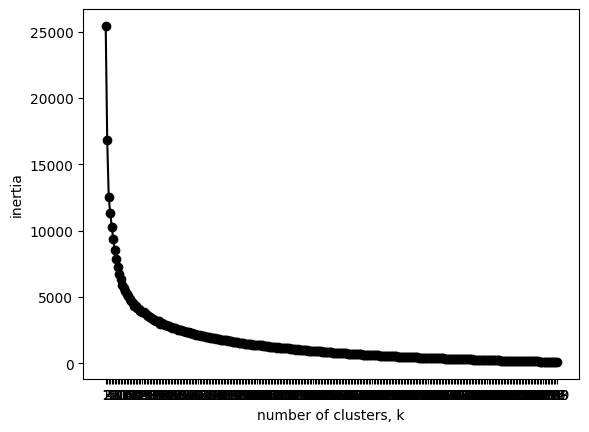

In [101]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [102]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  39


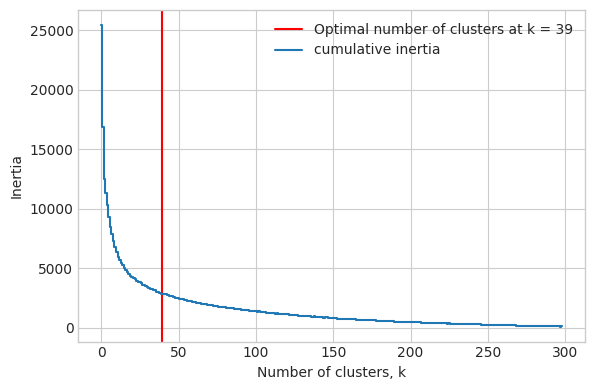

In [103]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [104]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
